# Sprint 1 Report

## Introduction

For sprint 1 the MDP of the simple RPG has been refined and dynamic programming has been applied to it to find an optimal policy.


## MDP

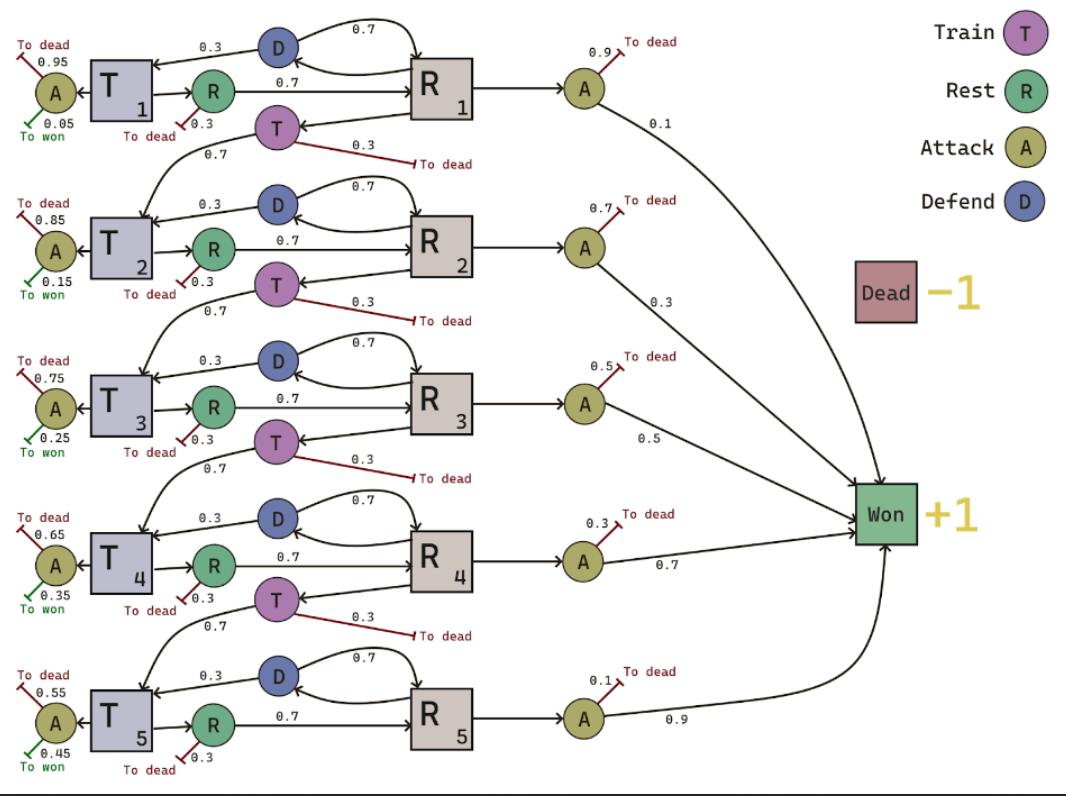

The only notable difference between the sprint 0 version and the new one is in the way it's coded: states are now frozendicts with some formatting rules added. This is because the code looks cleaner using objects than when using strings, and in order to keep the states as keys in the transitions dictionary they had to be frozen.

In [81]:
from math import isclose

from frozendict import frozendict
from random import choice, choices


class State(frozendict):
    def __new__(cls, *args, **kwargs):
        return frozendict.__new__(cls, *args, **kwargs)

    def __str__(self):
        if 'title' in self:
            return self['title']

        return f"L{self['level']} ({'T' if self['tired'] else 'R'})"

    def __repr__(self):
        return self.__str__()


class MDP:
    def __init__(self, states, statesPlus, actions, transitions=None, rewards=None, gamma=0.9, eps=1e-6, T=100, costOfLiving=0,
                 startingState=None):
        self.states = states
        self.statesPlus = statesPlus
        self.actions = actions
        self.transitions = transitions
        self.rewards = rewards
        self.gamma = gamma
        self.eps = eps
        self.T = T
        self.costOfLiving = costOfLiving

        self.startingState = startingState if startingState else states[0]
        self.currentState = self.startingState
        self.stepsTaken = 0

        self.checkProbabilities()

    def checkProbabilities(self):
        for s, a in self.transitions.items():
            for action, outcomes in a.items():
                try:
                    assert isclose(sum(outcomes.values()), 1,
                                   abs_tol=1e-4)  # Making sure the sum of outcomes is effectively 1
                except AssertionError:
                    raise AssertionError(f"Probability not 1: {s} + {action} -> {outcomes.values()}")

                for o, chance in outcomes.items():
                    try:
                        assert 0 <= chance <= 1
                    except AssertionError:
                        raise AssertionError(f"Invalid probability 1: {s} + {action} -> {o} ({chance})")


    def reset(self):
        self.currentState = self.startingState
        self.stepsTaken = 0

        return self.currentState

    @property
    def stateSpace(self) -> int:
        return len(self.states)

    @property
    def allActions(self) -> set:
        return set([a for A in self.actions.values() for a in A])

    @property
    def actionSpace(self) -> int:
        return len(self.allActions)  # To set to remove duplicate actions

    def getActions(self) -> list:
        return self.actions[self.currentState]

    def isTerminal(self, state):
        return state not in self.transitions

    def getReward(self, state, action, newState):
        return self.rewards.get(state, {}).get(action, {}).get(newState, 0) + self.costOfLiving

    def step(self, action, message=False):
        if action not in self.actions[self.currentState]:
            print('\tInvalid action:', action)
            return (self.currentState,
                    0,
                    False,
                    False,
                    "Invalid")

        possibleOutcomes = self.transitions[self.currentState][action]  # {s: chance, s: chance, etc.}
        newState = choices(list(possibleOutcomes.keys()), list(possibleOutcomes.values()))[0]
        reward = self.getReward(self.currentState, action, newState)

        if message:
            print(f"\t{self.currentState} -> {newState} via {action} (reward of {reward:.2f})")

        self.stepsTaken += 1
        self.currentState = newState

        return (newState,
                reward,
                self.isTerminal(newState),
                # In our case we treat 'sinks' (states with no further transitions) as terminal.
                self.stepsTaken >= self.T,
                None)  # What should info be?


def Test(mdp: MDP, how: str, maxLength: int) -> None:
    state = mdp.reset()  # reset/re-initialize
    totalRewards = 0

    print(f"Testing MDP with action '{how}' for {maxLength} turns.")
    for _ in range(maxLength):
        action = choice(mdp.getActions()) if how == 'random' else how

        newState, reward, terminated, truncated, info = mdp.step(
            action)  # execute an action in the current state of MDP

        if info == 'Invalid':
            return

        totalRewards += reward
        print(f"\t{state} -> {newState} via {action} (reward of {reward:.2f}, total of {totalRewards:.2f})")

        if terminated:
            print('\tDone!')
            break

        state = newState


def ActionsFromTransitions(t: dict) -> dict:  # state: {action1: outcomes, action2: outcomes} -> state: [actions]
    return {s: list(A) for s, A in t.items()}


def StatesFromTransitions(t: dict) -> list:
    return list(t)

More code has also been added to generate the SAR for the model. The environment can now easily be tweaked.

In [82]:
from numpy.random import choice


def ToTired(s: State) -> State:
    return State(level=s['level'],
                 tired=True)


def ToRested(s: State) -> State:
    return State(level=s['level'],
                 tired=False)


def ToTrained(s: State) -> State:
    return State(level=s['level'] + 1,
                 tired=True)


def WinChance(s: State, maxLevel: int, invert: bool = False) -> float:
    # winChance = (1 / maxLevel) * s['level']
    winChance = 0.1 + (0.9 / (maxLevel - 1)) * (s['level'] - 1)

    if s['tired']:
        winChance /= 2

    return (1 - winChance) if invert else winChance


def GenerateMDP(maxLevel: int, attackedChance: float, costOfLiving: float = 0, startingState: State = None) -> MDP:
    states = [State(level=l, tired=t) for l in range(1, maxLevel + 1) for t in (True, False)]

    won, died = State(title="Won"), State(title="Died")
    statesPlus = states + [won, died]

    transitions = {}

    for s in states:
        t = {'attack': {won: WinChance(s, maxLevel),
                        died: WinChance(s, maxLevel, True)}}

        if s['tired']:
            t['rest'] = {ToRested(s): 1 - attackedChance,
                         died: attackedChance}
        else:
            t['defend'] = {s: 1 - attackedChance,
                           ToTired(s): attackedChance}

            if s['level'] < maxLevel:
                t['train'] = {ToTrained(s): 1 - attackedChance,
                              died: attackedChance}

        transitions[s] = t

    rewards = {s: {'attack': {won: 1, died: -1},
                   'defend': {died: -1},
                   'train': {died: -1},
                   'rest': {died: -1}}
               for s in states}


    return MDP(states,
               statesPlus,
               ActionsFromTransitions(transitions),
               transitions=transitions,
               rewards=rewards,
               costOfLiving=costOfLiving,
               startingState=states[0] if not startingState else startingState)

### Testing

Since most of the code is the same as the previous sprint, not much has to be tested.

In [83]:
ATTACKED_CHANCE = 0.3
MAX_LEVEL = 5
COST_OF_LIVING = 0

mdp = GenerateMDP(MAX_LEVEL, 
                  ATTACKED_CHANCE, 
                  COST_OF_LIVING, 
                  State(level=1, tired=False))

Test(mdp, 'attack', 5)
Test(mdp, 'defend', 5)
Test(mdp, 'train', 5)
Test(mdp, 'rest', 5)
Test(mdp, 'random', 5)


mdp = GenerateMDP(MAX_LEVEL,
                  ATTACKED_CHANCE,
                  COST_OF_LIVING,
                  State(level=3, tired=True))

Test(mdp, 'attack', 5)
Test(mdp, 'defend', 5)
Test(mdp, 'train', 5)
Test(mdp, 'rest', 5)
Test(mdp, 'random', 5)



Testing MDP with action 'attack' for 5 turns.
	L1 (R) -> Died via attack (reward of -1.00, total of -1.00)
	Done!
Testing MDP with action 'defend' for 5 turns.
	L1 (R) -> L1 (R) via defend (reward of 0.00, total of 0.00)
	L1 (R) -> L1 (T) via defend (reward of 0.00, total of 0.00)
	Invalid action: defend
Testing MDP with action 'train' for 5 turns.
	L1 (R) -> Died via train (reward of -1.00, total of -1.00)
	Done!
Testing MDP with action 'rest' for 5 turns.
	Invalid action: rest
Testing MDP with action 'random' for 5 turns.
	L1 (R) -> Won via attack (reward of 1.00, total of 1.00)
	Done!
Testing MDP with action 'attack' for 5 turns.
	L3 (T) -> Died via attack (reward of -1.00, total of -1.00)
	Done!
Testing MDP with action 'defend' for 5 turns.
	Invalid action: defend
Testing MDP with action 'train' for 5 turns.
	Invalid action: train
Testing MDP with action 'rest' for 5 turns.
	L3 (T) -> L3 (R) via rest (reward of 0.00, total of 0.00)
	Invalid action: rest
Testing MDP with action 'ran

## Dynamic Programming

Now that the environment is done, DP can be applied to it. All the necessary functions for GPI have been implemented. Gamma is set to $\gamma=1$ because a lower rate resulted in worse performance.

In [84]:
from copy import deepcopy


GAMMA = 1


def Gt(state: State, action: str, nextState: State, mdp: MDP, vTable: dict) -> float:
    return mdp.getReward(state, action, nextState) + (GAMMA * vTable[nextState])


# Bellman equation for V
def CalculateV(policy: dict, state: State, mdp: MDP, vTable: dict) -> float:
    if mdp.isTerminal(state):
        return 0

    return sum(p * CalculateQ(state, a, mdp, vTable)
               for a, p in policy[state].items())


# Bellman equation for Q
def CalculateQ(state: State, action: str, mdp: MDP, vTable: dict) -> float:

    return sum(p * Gt(state, action, sNext, mdp, vTable)
               for sNext, p in mdp.transitions[state][action].items())


def UpdateQ(state: State, policy: dict, mdp: MDP, vTable: dict) -> dict:
    return {a: CalculateQ(state, a, mdp, vTable) for a in policy[state]}


def ArgMax(d: dict):  # np.argmax was causing issues.
    for k in d:
        if d[k] == max(d.values()):
            return k


def UpdatePolicy(policy: dict, actionValues: dict) -> dict:  # Choosing the optimal action from our actionValues.
    updatedPolicy = deepcopy(policy)

    for state in policy:
        optimalAction = ArgMax(actionValues[state])

        updatedPolicy[state] = {a: int(a == optimalAction) for a in policy[state]}

    return updatedPolicy


def UpdateV(vTable: dict, policy: dict, mdp: MDP, sweeps: int) -> dict:
    for _ in range(sweeps):
        tableCopy = deepcopy(vTable)

        vTable = {s: CalculateV(policy, s, mdp, tableCopy) for s in tableCopy}

    return vTable


def GPI(policy: dict, mdp: MDP, maxIterations: int = 10) -> dict:
    vTable = {s: 0 for s in mdp.statesPlus}

    for _ in range(maxIterations):
        # Evaluation
        vTable = UpdateV(vTable, policy, mdp, sweeps=100)
        actionValues = {s: UpdateQ(s, policy, mdp, vTable) for s in mdp.states}

        # Improvement
        newPolicy = UpdatePolicy(policy, actionValues)
        
        if newPolicy == policy:  # No more changes, hence the optimal policy has been found.
            return policy
            

    return policy

## Prediction

There are a couple of predictions that can be made about the optimal policy:
1. since the tired state cuts the chances of winning a fight in half, it almost always makes sense to rest first before anything else;
2. there might not be a direct cost of living, but the random attack chance does insensitive the agent make a trade-off between leveling up and not taking too many steps to do so;
    - it is worth noting that with a positive cost of living (more so a reward of living) the agent will likely enter a defend-rest loop to stay alive as long as possible.

## Testing

The next couple of functions tie it all together: here it is possible to generate a random policy to start GPI with and compare to afterwards using a simple simulation of the model.

In [85]:
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter


def Simulate(policy: dict, mdp: MDP, episodes: int, steps: int) -> tuple[list, list]:
    rewards = []
    stepCounts = []

    for episode in range(episodes):
        totalRewards = 0
        stepCount = 0

        state = mdp.reset()

        for step in range(steps):
            action = choice(list(policy[state].keys()),
                            p=list(policy[state].values()))

            state, reward, terminated, truncated, info = mdp.step(action, message=False)
            totalRewards += reward

            stepCount += 1
            if terminated:
                break

        rewards.append(totalRewards)
        stepCounts.append(stepCount)

    return rewards, stepCounts


def GenerateRandomPolicy(mdp: MDP) -> dict:
    return {s: {a: 1 / len(actions) for a in actions}
            for s, actions in ActionsFromTransitions(mdp.transitions).items()}


def Plot(data: list, title: str, color: str, movingWindowSize: int = 20) -> None:
    print(f'{title} mean reward:', sum(data) / len(data))

    plt.plot(savgol_filter(data, movingWindowSize, 3),
             label=f'Random Policy', color=color)


def CompareToRandom(policy: dict, episodes: int, steps: int, mdp: MDP) -> None:
    rewardsRandom = Simulate(GenerateRandomPolicy(mdp), mdp, episodes, steps)[0]

    rewardsGPI = Simulate(policy, mdp, episodes, steps)[0]

    Plot(rewardsRandom, 'Random Policy', 'orange')
    Plot(rewardsGPI, 'GPI Policy', 'blue')

    plt.title(f'Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()



Random Policy mean reward: -1.0311999999999695
GPI Policy mean reward: -0.8316499999999618


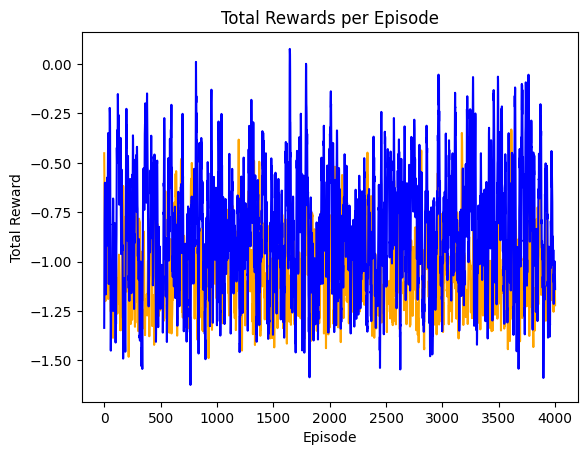

In [96]:
gpiPolicy = GPI(GenerateRandomPolicy(mdp), mdp)
CompareToRandom(gpiPolicy,
                4000,
                100,
                mdp)

In [97]:
gpiPolicy

{L1 (T): {'attack': 0, 'rest': 1},
 L1 (R): {'attack': 0, 'defend': 0, 'train': 1},
 L2 (T): {'attack': 0, 'rest': 1},
 L2 (R): {'attack': 0, 'defend': 0, 'train': 1},
 L3 (T): {'attack': 0, 'rest': 1},
 L3 (R): {'attack': 1, 'defend': 0, 'train': 0},
 L4 (T): {'attack': 0, 'rest': 1},
 L4 (R): {'attack': 1, 'defend': 0, 'train': 0},
 L5 (T): {'attack': 0, 'rest': 1},
 L5 (R): {'attack': 1, 'defend': 0}}

The GPI generated policy does significantly better than the random policy, which is a good first sign. With the GPI policy the agent always chooses to rest when tired, trains up to level 3, and then attacks with a 50% chance of winning.

Another interesting test is to see how the policy changes if the chance of getting attacked is much lower. This would make training less risky and defending less useful.

Random Policy mean reward: -0.8115
GPI Policy mean reward: -0.246


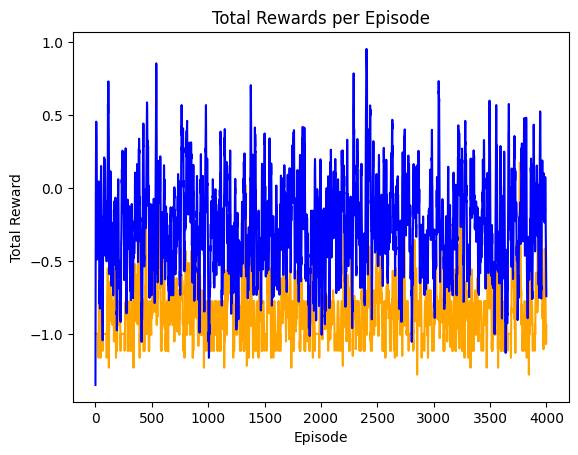

In [98]:
ATTACKED_CHANCE = 0.1

mdp = GenerateMDP(MAX_LEVEL, ATTACKED_CHANCE, COST_OF_LIVING)

gpiPolicy = GPI(GenerateRandomPolicy(mdp), mdp)
CompareToRandom(gpiPolicy,
                4000,
                100,
                mdp)

In [99]:
gpiPolicy

{L1 (T): {'attack': 0, 'rest': 1},
 L1 (R): {'attack': 0, 'defend': 0, 'train': 1},
 L2 (T): {'attack': 0, 'rest': 1},
 L2 (R): {'attack': 0, 'defend': 0, 'train': 1},
 L3 (T): {'attack': 0, 'rest': 1},
 L3 (R): {'attack': 0, 'defend': 0, 'train': 1},
 L4 (T): {'attack': 0, 'rest': 1},
 L4 (R): {'attack': 0, 'defend': 0, 'train': 1},
 L5 (T): {'attack': 0, 'rest': 1},
 L5 (R): {'attack': 1, 'defend': 0}}

As is to be expected, the agent now trains up to max level before attacking. Because this certain chain of actions (training to max level and then attacking) is much less risky, it is much higher in expected value than a random policy, explaining the bigger difference between it and a random policy.

# Conclusion

The next most interesting step to take is to remove the enemy and instead add in another agent. The environment will then no longer be deterministic so another method for the policy creation should be used, such as Monte Carlo or TD.

## Contributions


Robert:
- Created the basic MDP environment with states, actions, rewards, and transition probability.
- Cleaned up the code Sol wrote.

Sol:
- Implemented the initial policy, policy evaluation, policy improvement and generalized policy iteration to find the optimal policy.
- Set up the initial document for sprint 1.